In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

import xgboost as xgb

import datetime

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import pickle
from prophet.serialize import model_to_json, model_from_json

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

In [85]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip
#!pip3 install prophet
#!pip install prophet

In [86]:
pd.set_option("display.float_format", "{:.3f}".format)

In [87]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

df = pd.read_csv('household_power_consumption.txt', sep=';')

KeyboardInterrupt: 

In [ ]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
del df['Date']
del df['Time']

df.set_index("DateTime", inplace=True)

C:\Users\jaros\AppData\Local\Temp\ipykernel_16920\3612928832.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [ ]:
df.isna().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Global_active_power,2075259,6534,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global_reactive_power,2075259,896,0.000,472786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Voltage,2075259,5168,?,25979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Global_intensity,2075259,377,1.000,169406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_metering_1,2075259,153,0.000,1840611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_metering_2,2075259,145,0.000,1408274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_metering_3,2049280.000,NaN,NaN,NaN,6.458,8.437,0.000,0.000,1.000,17.000,31.000


In [ ]:
df.isin(['?']).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3               0
dtype: int64

In [ ]:
df.replace('?', 'NaN', inplace=True)

In [ ]:
df['Global_active_power'] = df['Global_active_power'].astype('float')
df['Global_reactive_power'] = df['Global_reactive_power'].astype('float')
df['Voltage'] = df['Voltage'].astype('float')
df['Global_intensity'] = df['Global_intensity'].astype('float')
df['Sub_metering_1'] = df['Sub_metering_1'].astype('float')
df['Sub_metering_2'] = df['Sub_metering_2'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.000,1.092,1.057,0.076,0.308,0.602,1.528,11.122
Global_reactive_power,2049280.000,0.124,0.113,0.000,0.048,0.100,0.194,1.390
Voltage,2049280.000,240.840,3.240,223.200,238.990,241.010,242.890,254.150
Global_intensity,2049280.000,4.628,4.444,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2049280.000,1.122,6.153,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2049280.000,1.299,5.822,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2049280.000,6.458,8.437,0.000,0.000,1.000,17.000,31.000


In [ ]:
# Fill missing values with a value at the same time, one day ago

In [ ]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
df = df.fillna(df.shift(60*24*7))

In [ ]:
df.isna().sum()

Global_active_power      3
Global_reactive_power    3
Voltage                  3
Global_intensity         3
Sub_metering_1           3
Sub_metering_2           3
Sub_metering_3           3
dtype: int64

In [ ]:
df = df.fillna(df.shift(60*24*7))

In [ ]:
df.isna().sum()

Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

In [ ]:
df = df.fillna(df.shift(60*24))

In [ ]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.000,1.089,1.056,0.076,0.308,0.598,1.526,11.122
Global_reactive_power,2075259.000,0.124,0.113,0.000,0.048,0.100,0.194,1.390
Voltage,2075259.000,240.846,3.235,223.200,239.000,241.020,242.880,254.150
Global_intensity,2075259.000,4.617,4.439,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2075259.000,1.121,6.152,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2075259.000,1.296,5.814,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2075259.000,6.454,8.434,0.000,0.000,1.000,17.000,31.000


In [ ]:
# Standardization (watt-hour)
df["Global_active_power"] = df["Global_active_power"].apply(lambda x: (x*1000)/60)
df["Global_reactive_power"] = df["Global_reactive_power"].apply(lambda x: (x*1000)/60)

In [ ]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.000,18.151,17.601,1.267,5.133,9.967,25.433,185.367
Global_reactive_power,2075259.000,2.063,1.879,0.000,0.800,1.667,3.233,23.167
Voltage,2075259.000,240.846,3.235,223.200,239.000,241.020,242.880,254.150
Global_intensity,2075259.000,4.617,4.439,0.200,1.400,2.600,6.400,48.400
Sub_metering_1,2075259.000,1.121,6.152,0.000,0.000,0.000,0.000,88.000
Sub_metering_2,2075259.000,1.296,5.814,0.000,0.000,0.000,1.000,80.000
Sub_metering_3,2075259.000,6.454,8.434,0.000,0.000,1.000,17.000,31.000


In [ ]:
# Global_active_power   [watt-hour]
# Global_reactive_power [watt-hour]
# Voltage               [volt]
# Global_intensity      [ampere]
# Sub_metering_1        [watt-hour]
# Sub_metering_2        [watt-hour]
# Sub_metering_3        [watt-hour]

In [ ]:
df_t4 = df[['Global_active_power','Sub_metering_1','Sub_metering_2','Sub_metering_3']]

In [ ]:
# Dickey-Fuller test function
def dickey_fuller_test(df):
    print('Test results:')
    df_test = adfuller(df, autolag='AIC')
    df_out = pd.Series(df_test[0:4], index=['Test Statistic','p-value','Lags','Number of observations'])
    for key,value in df_test[4].items():
        df_out['Critical Val (%s)'%key] = value
    print(df_out)

In [ ]:
# Performing on 2 year time data (more than half)
dickey_fuller_test(df.index[range(1052640)])

Test results:
Test Statistic               -57.692
p-value                        0.000
Lags                          23.000
Number of observations   1052616.000
Critical Val (1%)             -3.430
Critical Val (5%)             -2.862
Critical Val (10%)            -2.567
dtype: float64


In [ ]:
# Since the p-value is less than 0.05, we can't reject the null hypothesis.
# This means the time series is stationary type.

In [ ]:
# Correlation (pearson)
pear = df.corr(method='pearson', numeric_only=True)

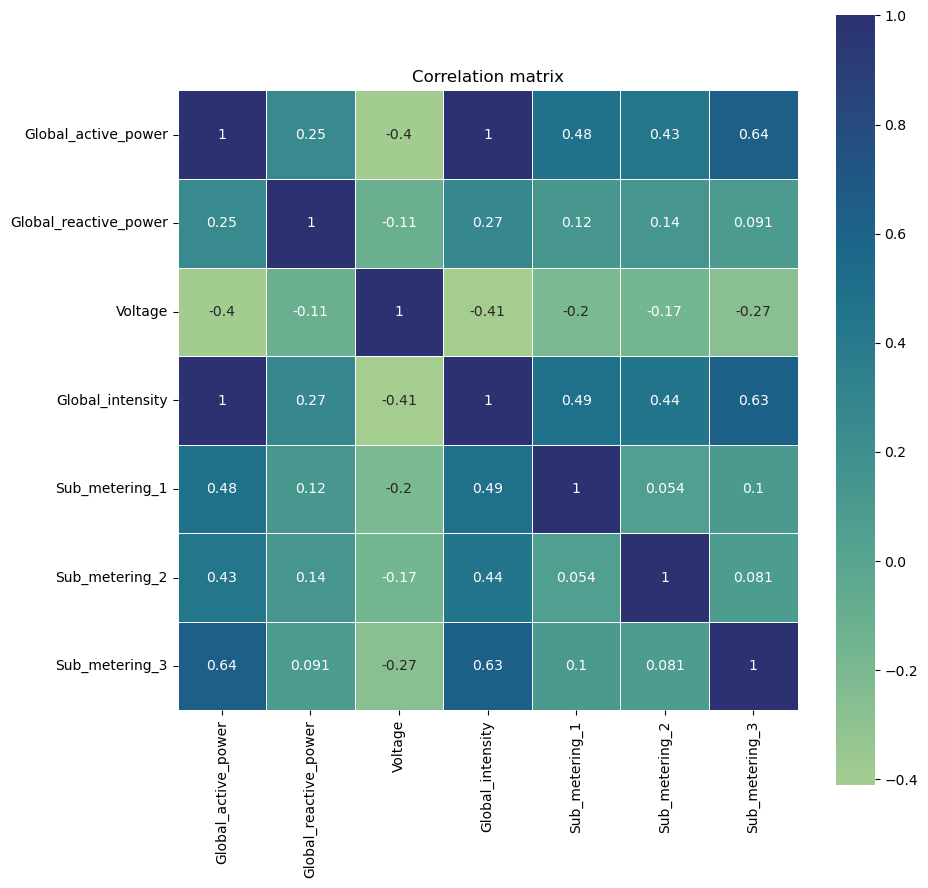

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pear, annot=True, robust =True, linewidth=.5, square=True, cmap="crest")
plt.title("Correlation matrix");

In [ ]:
# Time series decomposition lets us separate the trend and seasonality in our data
# so we can see what's happening beneath

In [104]:
seas_decomp = pd.DataFrame({'ds': df_t4.DateTime, 'y': df_t4.Global_active_power})

In [ ]:
m = Prophet(growth='flat', interval_width=0.95).fit(seas_decomp)

In [ ]:
future = m.make_future_dataframe(periods=1440)
future['cap'] = 8.5

In [ ]:
fcst = m.predict(future)

In [ ]:
with open('model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [109]:
with open('model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [ ]:
fcst.to_pickle("forecast.pkl")

In [110]:
fcast = pd.read_pickle("forecast.pkl")

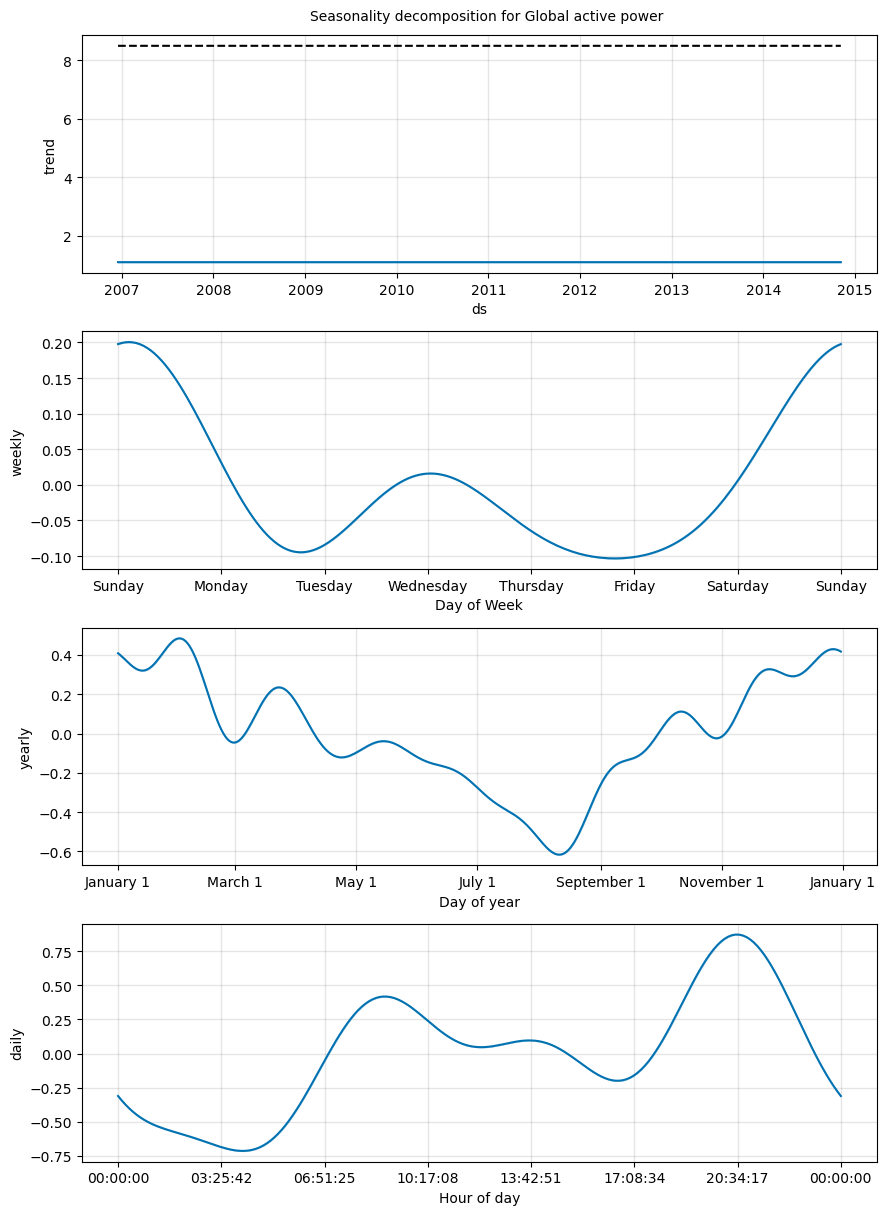

In [150]:
fcast_components = m.plot_components(fcast, plot_cap=True, uncertainty=True).text(x=0.35, y=1.0, s='Seasonality decomposition for Global active power')

In [ ]:
cv_gap = cross_validation(m,
                         horizon='90 days',
                         period='30 days',
                         initial='730 days',
                         parallel='threads')

In [ ]:
cv_gap.to_pickle("df_cv.pkl")

In [121]:
cv_gap = pd.read_pickle("df_cv.pkl")

In [151]:
cv_gap_p = performance_metrics(cv_gap)
cv_gap_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,8 days 19:41:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
1,8 days 19:42:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
2,8 days 19:43:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
3,8 days 19:44:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
4,8 days 19:45:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965


In [152]:
cv_gap_p.to_csv('performance_metrics.csv')

In [153]:
cv_gap_p = pd.read_csv('performance_metrics.csv')
cv_gap_p.head()

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0,8 days 19:41:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
1,1,8 days 19:42:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
2,2,8 days 19:43:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
3,3,8 days 19:44:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
4,4,8 days 19:45:00,0.692,0.832,0.601,1.066,0.572,0.651,0.965
